# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$
 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$w^{k+1} = w^{k} - \alpha^k \nabla_{w^k} \left( \frac{1}{n} \sum\limits_{i=1}^n L(w^{k}) + \frac{1}{\tilde C} R(w^{k})\right) = \\
= w^{k} - \alpha^k \left( \frac{1}{n} \sum\limits_{i=1}^n (\langle x_i, w^k \rangle - y_i) x_i + \frac{2}{\tilde C} w^k \right) =\\
= w^{k} - \alpha^k \left( \frac{1}{n} \sum\limits_{i=1}^n (\langle x_i, w^k \rangle - y_i) x_i + \frac{1}{C} w^k \right) ,$$
где $w^{k+1} = w_{new},\; w^{k} = w_{old},\; C = \frac{\tilde C}{2}$.
          
Символически, формулу для градиента можно описать так:
$$ \nabla_w Q = E[\nabla_w L] + penalty (w).$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***
$$w^{k+1} 
= w^{k}-\alpha^k \nabla_{w^k} \left( \frac{1}{n} \sum\limits_{i=1}^n L(w^{k}) + \frac{1}{\tilde C} R(w^{k})\right) =\\
= w^{k}-\alpha^k \left( \frac{1}{n}\sum\limits_{i=1}^n (a_i - y_i) x_i + \frac{1}{C} w^k \right). $$
<br>     
       
$$ \nabla_w L(w) 
= \nabla_w \left( y_i \log a_i + (1 - y_i) \log(1-a_i) \right) =\\
= y_i \frac{1}{a_i} a_i' + (1-y_i) \frac{(-1)}{1-a_i}a_i'
%%= y_i \frac{1}{a_i} \frac{wa_i^2}{e^{wx_i}} + (1-y_i) \frac{-1}{1-a_i}\frac{wa_i^2}{e^{wx_i}} 
= y_i (a_i-1) x_i + (1-y_i) a_i x_i
= (a_i - y_i) x_i.
$$
          
<br>     
     
$$ a_i'  = \sigma'(\langle w,x_i \rangle) 
= - \frac{e^{-\langle w, x_i \rangle}x_i}{(1 + e^{-\langle w,x_i \rangle})^2} 
= - e^{- \langle w, x_i \rangle}  a_i^2 x_i 
= \frac{a_i-1}{a_i} a_i^2 x_i  
= (a_i-1)a_i x_i.
$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***
$$ Q(w) = \frac{1}{N} (X\cdot w-y)^T(X\cdot w-y),$$

$$ \nabla Q(w) = 2X^TXw - 2X^Ty ,$$

$$ H(Q(w)) = 2X^TX = \left( 2 \langle x_i,x_j \rangle \right)_{i,j=1\ldots D} \; .$$

Так как $x_1,\ldots x_D \in \mathbb{R}^D$ линейно независимы (по условию), то $ H(Q(w)) $ - положительно определенная матрица. Следовательно, $w$ действительно является точкой минимума функции $Q(w)$.



$$ Q_r(w) = \frac{1}{N} (X\cdot w-y)^T(X\cdot w-y) + \alpha R(w), $$

$$ \nabla Q_r(w) = 2X^TXw - 2X^Ty + 2 \alpha w = 0, $$

$$ (X^TX + \alpha I)w = X^Ty, $$

$$ w = (X^TX + \alpha I)^{-1} X^Ty .$$

$L2$ регуляризация уменьшает число обусловленности, повышая точность обращения матрицы, если эта матрица имеет зависимые признаки.


Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$ ( -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i)) )'_{a(x_i)} = 
( -p_1 \log a - p_0 \log(1-a) )'
= 0 $$

$$
\frac{-p_1}{a} + \frac{p_0}{1 - a} =
\frac{-p_1}{a} + \frac{1 - p_1}{ 1 - a} =
0 $$
Следовательно $a(x_i) = p_1 = p(y_i = 1 | x_i)$ - точка экстремума.

$$ \left( -p_1 \log a - p_0 \log(1-a) \right)''|_{p_1} = 
\frac{1}{p_1} + \frac{1}{p_0} > 0$$
Следовательно, $a(x_i) = p(y_i = 1 | x_i)$ - точка минимума.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***
<br> Нет. <br>
Регуляризация следит за тем, чтобы при маленьком изменении признака не было слишком большого изменения ответа, т.е. за тем, чтобы не было переобучения. Параметр $w_0$ относится к вектору весов для простоты записи. Он не умнажается ни на какой признак, а является всего лишь значением функции в нуле. Поэтому нет никакого смысла ограничивать $w_0$, и сильно уменьшать варианты построения разделяющей гиперплоскости.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
 
    if batch_size > X.shape[0]:
        batch_size = X.shape[0]
    if shuffle:
        new_ids = np.random.permutation(X.shape[0])
    else:
        new_ids = np.arange(X.shape[0])
    number_batches = X.shape[0] // batch_size
    for i in range(number_batches):
        indices = range(batch_size*i, batch_size*(i+1))
        X_batch = X[new_ids[indices]]
        y_batch = y[new_ids[indices]]
        yield (X_batch, y_batch)
    if len(X) % batch_size != 0:
        indices = batch_size*(i+1)
        X_batch = X[new_ids[indices:]]
        y_batch = y[new_ids[indices:]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
# my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [3]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    sigm_value_x = 1 / (1+np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', th=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.th = th
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.weights = []
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        loss = 0.
        if self.model_type == 'lin_reg':
            for x, y in zip(X_batch, y_batch):
                a = np.dot(x, self.weights)
                loss += (a-y)**2
            loss /= len(y_batch)
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C
        elif self.model_type == 'log_reg':
            for x, y in zip(X_batch, y_batch):
                a = sigmoid(np.dot(x, self.weights))
                loss -= y * np.log2(a) + (1-y) * np.log2(1-a)
            loss /= len(y_batch)
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        loss_grad = 0.
        if self.model_type == 'lin_reg':
            for x, y in zip(X_batch, y_batch):
                a = np.dot(x, self.weights)
                loss_grad += (a-y)*x
            loss_grad /= len(y_batch)
            R = self.weights / self.C
            R[0] = 0
            loss_grad += R
        elif self.model_type == 'log_reg':
            for x, y in zip(X_batch, y_batch):
                dot = np.dot(x, self.weights)
                a = sigmoid(dot)
                loss_grad += (a-y)*x
            loss_grad /= len(y_batch)
            R = self.weights / self.C
            R[0] = 0
            loss_grad += R
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        
        alpha_k = self.alpha / self.curr_epoch**(0.005)
        self.weights = self.weights - alpha_k * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        if self.model_type == 'lin_reg':
            y = y - np.mean(y)
        X = np.hstack((np.ones((X.shape[0],1)), X))
        self.weights = X[np.random.randint(0, X.shape[0]-1)]
        self.curr_epoch = 0
        for n in range(0, self.max_epoch):
            self.curr_epoch += 1
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=50)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        X = np.hstack((np.ones((X.shape[0],1)), X))
        y_hat = np.array([])        
        if self.model_type == 'lin_reg':
            dot_func = lambda x: np.dot(x, self.weights)
            y_hat = np.apply_along_axis(dot_func, 1, X)

        elif self.model_type == 'log_reg':
            dot_func = lambda x: True if (sigmoid(np.dot(x, self.weights)) - self.th > 0) else False
            y_hat = np.apply_along_axis(dot_func, 1, X).astype(int)
    
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [4]:
def plot_decision_boundary(clf):
    x_1 = 0
    x_2 = - clf.weights[0] / clf.weights[1]
    f_0 = [x_1, x_2]
    
    x_1 = - clf.weights[0] / clf.weights[2]
    x_2 = 0
    f_1 = [x_1, x_2]
    
    plt.plot(f_0, f_1)

weights to lin_reg: [-0.62448054  0.14490744 -0.1696018 ]
weights to log_reg: [-4.06414514  0.93829423 -0.94721768]


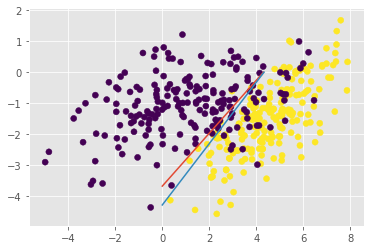

In [5]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
        
lin_reg = MySGDClassifier(batch_generator=batch_generator, model_type='lin_reg', alpha=0.05, C=100, max_epoch=100)
lin_reg.fit(X,y)
plot_decision_boundary(lin_reg)
print("weights to lin_reg:", lin_reg.weights)

log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', alpha=0.05, C=100, max_epoch=250)
log_reg.fit(X,y)
plot_decision_boundary(log_reg)
print("weights to log_reg:", log_reg.weights)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [12]:
## Your Code Here
def plot_loss(model):
    max_epoch = model.max_epoch
    N = len(model.errors_log['loss']) // max_epoch
    y_data = np.array([])
    x_data = np.array([])
    for i in range(max_epoch):
        x_data = np.append(x_data, i)
        y_data = np.append(y_data, np.mean(model.errors_log['loss'][N*i : N*(i+1)]))
    plt.plot(x_data, y_data)

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2


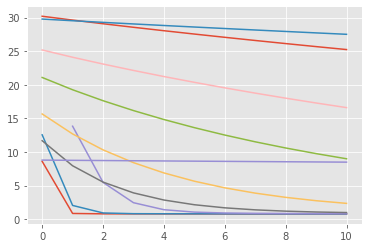

In [13]:
for alpha in np.logspace(-3, -6, 10):
    log_reg = MySGDClassifier(batch_generator=batch_generator, max_epoch=11, model_type='log_reg', alpha=alpha)
    log_reg.fit(X,y)
    plot_loss(log_reg)

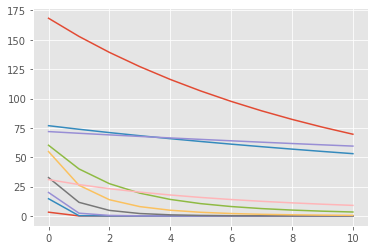

In [14]:
for alpha in np.logspace(-3, -6, 10):
    lin_reg = MySGDClassifier(batch_generator=batch_generator, max_epoch=11, model_type='lin_reg', alpha=alpha)
    lin_reg.fit(X,y)
    plot_loss(lin_reg)

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in add
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in add
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in subtract
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overfl

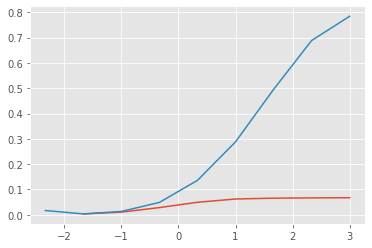

In [15]:
## Your Code Here
lin_x = np.array([])
lin_y = np.array([])
log_x = np.array([])
log_y = np.array([])
for C in np.logspace(3, -3, 10):
    lin_reg = MySGDClassifier(batch_generator=batch_generator, model_type='lin_reg', C=C)
    lin_reg.fit(X,y)
    lin_x = np.append(lin_x, np.log10(C))
    lin_y = np.append(lin_y, np.mean(np.abs(lin_reg.weights)))
    
    log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', C=C)
    log_reg.fit(X,y)
    log_x = np.append(log_x, np.log10(C))
    log_y = np.append(log_y, np.mean(np.abs(log_reg.weights)))
    
plt.plot(lin_x, lin_y)
plt.plot(log_x, log_y)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [6]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [7]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [8]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [9]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

In [13]:
log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', alpha=0.1, C=1000)
log_reg.fit(X_train_scale,y_train)
my_pred = log_reg.predict(X_train_scale)
print("Predict to X_train_scale:", f1_score(y_train, my_pred, average='binary'))

log_reg.fit(X_train,y_train)
my_pred = log_reg.predict(X_train)
print("Predict to X_train:", f1_score(y_train, my_pred, average='binary'))

Predict to X_train_scale: 0.5226149752945648


/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


Predict to X_train: 0.38310236924452384


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [22]:
def kfold_generator(groups_train, n_splits=10):
    all_groups = np.unique(groups_train)
    fold_size = len(all_groups) // n_splits
    all_groups = np.random.permutation(all_groups)
    fold_groups = np.zeros((n_splits,fold_size), dtype=int)
    for i, group in enumerate(all_groups):
        fold = i // fold_size
        if fold == n_splits:
            break
        group_i = i % fold_size
        fold_groups[fold,group_i] = group
    fold_indices = {}
    for fold in range(n_splits):
        indices = np.array([], dtype = int)
        for group in fold_groups[fold]:
            indices = np.append(indices, np.argwhere(groups_train == group))
        fold_indices[fold] = indices

    for i in fold_indices:
        kf_test = fold_indices[i]
        kf_train = np.array([],dtype=int)
        for j in fold_indices:
            if i == j:
                continue
            kf_train = np.append(kf_train, fold_indices[j])
        kf_tuple = [kf_train, kf_test]
        yield (kf_train, kf_test)
        
def cross_validation(model, groups_train, kfold_generator, X, y, folds=10, verbose=False):    
    total_score = 0
    for i, tuple_indices in enumerate(kfold_generator(groups_train, n_splits=folds)):
        train_index, test_index = tuple_indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if model.model_type == 'lin_reg':
            score = f1_score(y_test, np.around(y_pred).astype(int).astype(bool))
        else:
            score = f1_score(y_test, y_pred)
        total_score += score
        if verbose:
            print(i, "score:", f1_score(y_test, y_pred))
    mean_score = total_score / folds
    if verbose:
        print("MEAN_SCORE:", mean_score)
    return mean_score

def grid_cv(alpha_list, C_list, max_epoch_list, th_list, 
            X, y, groups_train, kfold_generator, batch_generator, 
            model_type='log_reg', folds=10, verbose=True):
    sample_scores = np.array([])
    sample_params = []
    for alpha in alpha_list:
        for C in C_list:
            for max_epoch in max_epoch_list:
                for th in th_list:                        
                    model = MySGDClassifier(batch_generator=batch_generator, model_type=model_type, 
                                            alpha=alpha, C=C, th=th, max_epoch=max_epoch)
                    curr_mean_score = cross_validation(model, groups_train, kfold_generator, X, y, folds=folds)
                    sample_scores = np.append(sample_scores, curr_mean_score)
                    sample_tuple = (alpha, C, th, max_epoch)
                    sample_params.append(sample_tuple)
                    if verbose:
                        print("SCORE: ", curr_mean_score, end='\t\t')
                        print("(alpha = %s; C = %s; max_epoch = %s; th = %s)" % (alpha, C, max_epoch, th))
    best_score_index = np.argmax(sample_scores)
    best_score = sample_scores[best_score_index]
    best_params = sample_params[best_score_index]
    if verbose:
        print("\nBEST SCORE:\t", best_score)
        print("BEST PARAMS:\t", best_params)
    return best_score, best_params, sample_scores, sample_params

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [23]:
alpha_list = np.linspace(0.00001, 1, 3)
C_list = np.logspace(-1, 4, 3)
max_epoch_list = [10]
th_list = np.linspace(0.2, 0.8, 3)

best_score, best_params, _, _ = grid_cv(alpha_list, C_list, max_epoch_list, th_list, 
                                        X_train_scale, y_train, groups_train, kfold_generator, batch_generator, 
                                        model_type='lin_reg', folds=4, verbose=False);
best_score, best_params

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in multiply
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in add
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in add
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


(0.44911481663603875, (1.0, 31.622776601683793, 0.5, 10))

In [24]:
alpha_list = np.linspace(0.00001, 1, 3)
C_list = np.logspace(-1, 4, 3)
max_epoch_list = [10]
th_list = np.linspace(0.2, 0.8, 3)

best_score, best_params, _, _ = grid_cv(alpha_list, C_list, max_epoch_list, th_list, 
                                        X_train_scale, y_train, groups_train, kfold_generator, batch_generator, 
                                        model_type='log_reg', folds=4, verbose=False);
best_score, best_params

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in double_scalars
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in true_divide
/home/kirill/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in subtract


(0.6015743598353689, (1.0, 10000.0, 0.2, 10))

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [25]:
def write_to_submission_file(predicted_labels, test_data, out_file, target='target', index_label="pair_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels, index = np.asarray(test_data[index_label]), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [26]:
test_data = pd.read_csv("test_groups.csv") 
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, target))
    
y_test = []
X_test = []
groups_train = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_test.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
y_test = np.array(y_test)
groups_train = np.array(groups_train)
print (X_test.shape, y_test.shape, groups_train.shape)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_scale = scaler.transform(X_test)

(16627, 15) (16627,) (16627,)


In [27]:
log_reg = MySGDClassifier(batch_generator=batch_generator, model_type='log_reg', alpha=0.1, C=600, th=0.3, max_epoch=10)
log_reg.fit(X_train_scale, y_train)
y_pred = log_reg.predict(X_test_scale)
write_to_submission_file(y_pred, test_data, "y_pred.csv")

/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
/home/kirill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


In [28]:
log_reg.weights

array([-1.07000869, -0.11905394,  0.22587675,  0.21631733,  0.0669268 ,
        0.18233309, -0.06587198,  0.25307932,  0.12393003,  0.10897877,
        0.04700133,  0.10467245,  0.00839267, -0.07393478, -0.03943698,
        0.32341283])

In [29]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([11439,  5188]))

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***